In [1]:
%matplotlib inline

from ssm.dglm import NormalDLM
from ssm.univariatestructure import UnivariateStructure
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(8,4)

# Dynamic Generalised Linear Models

## Dynamic Linear Models

Dynamic linear models are a specific instance of state-space models where the observation and states are defined by

$$
Y_t|\theta_t,\Phi_t \sim \mathcal{N}\left(\theta_t; \mathsf{F}^T\theta_{t}, V\right) \\
\theta_t|\theta_{t-1},\Phi_t \sim \mathcal{N}\left(\theta_t;\mathsf{G}\theta_{t-1}, \mathsf{W}\right)
$$

### Locally constant

The _locally constant_ DLM corresponds to a simple state random walk, where the structure is defined by

$$
\mathsf{F}=\begin{bmatrix}1\end{bmatrix} \\
\mathsf{G}=\begin{bmatrix}1\end{bmatrix}
$$

This can be specified by using (in this case with a state variance of $\tau^2=1.4$):

In [2]:
lc = {'structure': UnivariateStructure.locally_constant(1.4)}
print("F = {}, G = {}".format(lc['structure'].F, lc['structure'].G))

F = [[1]], G = [[1]]


We can then instantiate a DLM (with observation variance $\sigma^2=1.4$):

In [3]:
ndlm = NormalDLM(structure=lc['structure'], V=1.4)

Assuming we have a state prior of

$$\theta_0 \sim \mathcal{N}\left(0, 1\right)$$

we can then generate the states $\theta_{1:T}$ and observation $y_{1:T}$:

In [4]:
# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = mvn(m0, C0).rvs()

lc['states'] = [state0]

for t in range(1, 100):
    lc['states'].append(ndlm.state(lc['states'][t-1]))
    
lc['obs'] = [None]
for t in range(1, 100):
    lc['obs'].append(ndlm.observation(lc['states'][t]))

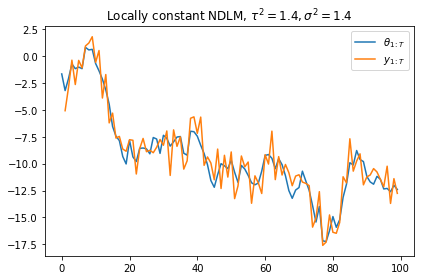

In [5]:
t = range(100)
plt.plot(t, lc['states'])
plt.plot(t, lc['obs'])
plt.legend([r"$\theta_{1:T}$", r"$y_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, $\tau^2=1.4, \sigma^2=1.4$")
plt.tight_layout()

### Locally linear

A _locally linear_ structure incorporates both an underlying mean and a trend. In this case the structure corresponds to
$$
\mathsf{F}=\begin{bmatrix}1 & 0\end{bmatrix}, \qquad \mathsf{G}=\begin{bmatrix}1 & 1 \\ 1 & 0 \end{bmatrix}.
$$
If we assume a state covariance of
$$
\mathsf{W}=\begin{bmatrix}0.1 & 0 \\ 0 & 0.1 \end{bmatrix}
$$
we can create the structure as:

In [6]:
W = np.matrix([[0.1, 0], [0, 0.1]])
ll = {'structure': UnivariateStructure.locally_linear(W)}

and the Normal DLM structure can be created (with a state variance of $\sigma^2=2.5$) using:

In [7]:
ndlm = NormalDLM(structure=ll['structure'], V=2.5)

In this case we will assume a state prior of
$$
\theta_0 \sim \mathcal{N}\left(\begin{bmatrix}0 & -1\end{bmatrix}, \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$
and we can generate the states and observations as:

In [8]:
# the initial state prior
m0 = np.array([0, -1])
C0 = np.identity(2)
state0 = mvn(m0, C0).rvs()

ll['states'] = [state0]

for t in range(1, 100):
    ll['states'].append(ndlm.state(ll['states'][t-1]))
    
ll['obs'] = [None]
for t in range(1, 100):
    ll['obs'].append(ndlm.observation(ll['states'][t]))

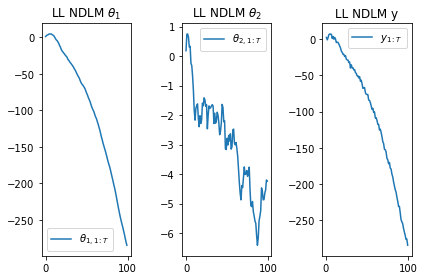

In [9]:
import matplotlib.pyplot as plt
t=range(100)
plt.subplot(1, 3, 1)
plt.plot(t, [state[0] for state in ll['states']])
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_1$")
plt.subplot(1, 3, 2)
plt.plot(t, [state[1] for state in ll['states']])
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_2$")
plt.subplot(1, 3, 3)
plt.plot(range(100), ll['obs'])
plt.legend([r"$y_{1:T}$"], loc=0)
plt.title(r"LL NDLM y")
plt.tight_layout()

### Fourier seasonality

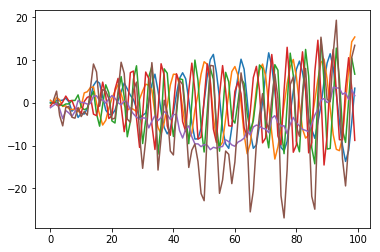

In [10]:
fourier = {'structure': UnivariateStructure.cyclic_fourier(period=10, harmonics=2, W=np.identity(4))}

ndlm_comp = NormalDLM(structure=(fourier['structure'] + lc['structure']), V=2.5)

# the initial state prior
m0 = np.array([0, 0, 0, 0, 0])
C0 = np.identity(5)
state0 = np.random.multivariate_normal(m0, C0)

fourier['states'] = [state0]

for t in range(1, 100):
    fourier['states'].append(ndlm_comp.state(fourier['states'][t-1]))
    
fourier['obs'] = [None]
for t in range(1, 100):
    fourier['obs'].append(ndlm_comp.observation(fourier['states'][t]))
    
import matplotlib.pyplot as plt
plt.plot(range(100), fourier['states'])
plt.plot(range(100), fourier['obs'])

### Filtering

#### Locally constant

In [11]:
from pssm.filters import KalmanFilter

kf = KalmanFilter(structure=lc['structure'], V=1.4)

m0 = np.array([0])
C0 = np.matrix([[1e3]])
filtered = {'ms': [m0], 'Cs': [C0]}

for t in range(1, 100):
    m, C = kf.filter(y=lc['obs'][t], m=filtered['ms'][t-1], C=filtered['Cs'][t-1])
    filtered['ms'].append(m)
    filtered['Cs'].append(C)

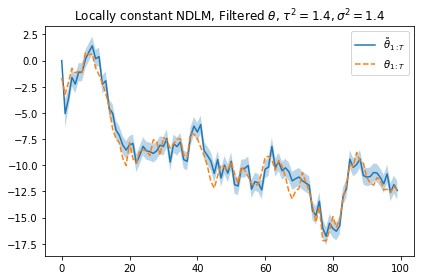

In [12]:
t = range(100)
plt.plot(t, filtered['ms'])
plt.plot(t, lc['states'], '--')
lb = []
ub = []
for m, C in zip(filtered['ms'], filtered['Cs']):
    lb.append(np.asscalar(m[0] - C[0][0]))
    ub.append(np.asscalar(m[0] + C[0][0]))
plt.fill_between(t[1:], lb[1:], ub[1:], alpha=0.3)
plt.legend([r"$\tilde{\theta}_{1:T}$", r"$\theta_{1:T}$"], loc=1)
plt.title(r"Locally constant NDLM, Filtered $\theta$, $\tau^2=1.4, \sigma^2=1.4$")
plt.tight_layout()

#### Locally linear

In [16]:
kf = KalmanFilter(structure=ll['structure'], V=2.5)

m0 = np.array([0, 0])
C0 = np.diag([1e3, 1e3])
filtered = {'ms': [m0], 'Cs': [C0]}

for t in range(1, 100):
    m, C = kf.filter(y=ll['obs'][t], m=filtered['ms'][t-1], C=filtered['Cs'][t-1])
    filtered['ms'].append(m)
    filtered['Cs'].append(C)

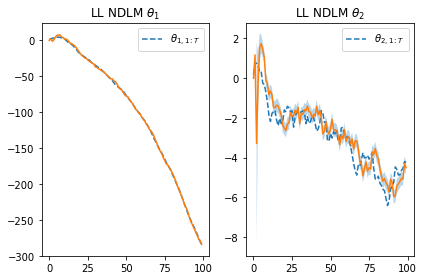

In [28]:
t=range(100)

lb = []
ub = []
for m, C in zip(filtered['ms'], filtered['Cs']):
    lb.append((m[0] - C.item((0,0)), m[1] - C.item((1,1)),))
    ub.append((m[0] + C.item((0,0)), m[1] + C.item((1,1)),))
    
plt.subplot(1, 2, 1)
plt.plot(t, [state[0] for state in ll['states']], '--')
plt.plot(t, [state[0] for state in filtered['ms']])
plt.fill_between(t[2:], [b[0] for b in lb[2:]], [b[0] for b in ub[2:]], alpha=0.3)
plt.legend([r"$\theta_{1,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_1$")
plt.subplot(1, 2, 2)
plt.plot(t, [state[1] for state in ll['states']], '--')
plt.plot(t, [state[1] for state in filtered['ms']])
plt.fill_between(t[2:], [b[1] for b in lb[2:]], [b[1] for b in ub[2:]], alpha=0.3)
plt.legend([r"$\theta_{2,1:T}$"], loc=0)
plt.title(r"LL NDLM $\theta_2$")

plt.tight_layout()